## Movie Recommendation




* use SGD algorithm to predict the rating given User Id, and Movie Id.

* Predicted rating $\hat{y}_{ij}$ for user i, movie j pair is calcuated as $\hat{y}_{ij} = \mu + b_i + c_j + u_i^T v_j$ , here we will be finding the best values of $b_{i}$ and $c_{j}$ using SGD algorithm with the optimization problem for N users and M movies is defined as

* $$
L = \min_{ b, c, \{ u_i \}_{i=1}^N, \{ v_j \}_{j=1}^M}
\quad
\alpha \Big(
    \sum_{j} \sum_{k} v_{jk}^2 
    + \sum_{i} \sum_{k} u_{ik}^2 
    + \sum_{i} b_i^2
    + \sum_{j} c_i^2
    \Big)
+ \sum_{i,j \in \mathcal{I}^{\text{train}}}
    (y_{ij} - \mu - b_i - c_j - u_i^T v_j)^2
$$

<ul>
<li><span class="math">$\(\mu\)$</span> : scalar mean rating</li>
<li><span class="math">$\(b_i\)$</span> : scalar bias term for user <span class="math">\(i\)</span></li>
<li><span class="math">$\(c_j\)$</span> : scalar bias term for movie <span class="math">\(j\)</span></li>
<li><span class="math">$\(u_i\)$</span> : K-dimensional vector for user <span class="math">\(i\)</span></li>
<li><span class="math">$\(v_j\)$</span> : K-dimensional vector for movie <span class="math">\(j\)</span></li>
</ul>

## Load Library

In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd
from sklearn.utils.extmath import randomized_svd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import seaborn as sns, numpy as np
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier

# Load Dataset

In [2]:
ratings_df = pd.read_csv('../input/movie-rating-recommendation/ratings_train.csv')

unique_users = len(ratings_df['user_id'].value_counts())
print("Number of unique users ", unique_users)

unique_movies = len(ratings_df['item_id'].value_counts())
print("Number of unique movies ", unique_movies)
ratings_df.head()

Number of unique users  943
Number of unique movies  1662


,user_id,item_id,rating
0,772,36,3
1,471,228,5
2,641,401,4
3,312,98,4
4,58,504,5


## Formulate as a Graph Problem

* We can construct a **weighted undirect graph** from a given pair of user and movie, and weight will be rating given to movie by user.
* we can construct this matrix like $A[i][j]=r_{ij}$ here $i$ is user_id, $j$ is movie_id and $r_{ij}$ is rating given by user $i$ to the movie $j$

### Adjancency matrix representaiton of User Movie Rating data

In [3]:


def get_rating_matrix(df, rowptr='user_id',colptr='item_id', y='rating'):
    '''In this function, we will compute sparse matrix representation of user movie and ratings'''
    
    csr = csr_matrix((df[y], (df[rowptr],df[colptr])))
    return csr
    
    
# Adjancey matrix representation
user_movie_matrix = get_rating_matrix(ratings_df)

In [4]:
def grader_matrix(matrix):
  assert(matrix.shape==(943,1681))
  return True
grader_matrix(user_movie_matrix)

True

## Implicit User Feautures and Movie Features using Matrix Factorization

We will Apply SVD decomposition on the Adjaceny matrix  $A$ and get three matrices $U, \sum, V$ such that $U \times \sum \times V^T = A$, <br> 
if $A$ is of dimensions $N \times M$ then <br>
$U$ is of $N \times k$, <br>
$\sum$ is of $k \times k$ and <br>
$V$ is $M \times k$ dimensions. <br>

   * Matrix $U$ can be represented as matrix **representation of users**, where each row $u_{i}$ represents a **k-dimensional vector for a user**

   * Matrix $V$ can be represented as matrix **representation of movies**, where each row $v_{j}$ represents a **k-dimensional vector for a movie.**


In [5]:

U, Sigma, VT = randomized_svd(user_movie_matrix, n_components=500,n_iter=5, random_state=1024)
print("User Matrix shape",U.shape)
print("Diagonal Matrix shape",Sigma.shape)
print("Movie Matrix shape",VT.T.shape)

User Matrix shape (943, 500)
Diagonal Matrix shape (500,)
Movie Matrix shape (1681, 500)


* Each **row of matrix $U$** can be said as **100 dimensional embedding of users** given user_movie pairs
* Each **row of matrix $VT$** can be said as **100 dimensional embedding of Movies** given user_movie pairs

### Mean User Rating

In [6]:
def m_u(ratings):
    '''In this function, we will compute mean for all the ratings'''
    mu = ratings.mean()
    return mu

mu_user = m_u(ratings_df['rating'])
print("Mean user rating across dataset for all movies", mu_user)

Mean user rating across dataset for all movies 3.529480398257623


In [7]:
def grader_mean(mu):
  assert(np.round(mu,3)==3.529)
  return True
mean_user_movie_rating=m_u(ratings_df['rating'])
grader_mean(mean_user_movie_rating)

True

In [8]:
def initialize(dim):
    '''In this function, we will initialize bias value 'B' and 'C'.'''
    # initalize the value to zeros 
    # return output as a list of zeros 
    
    return list(np.zeros(dim, dtype=int))
    



     

In [9]:
def grader_dim(b_i,c_j):
    assert(len(b_i)==943 and np.sum(b_i)==0)
    assert(len(c_j)==1681 and np.sum(c_j)==0)
    return True

    
b_i = initialize(user_movie_matrix.shape[0])
c_j = initialize(user_movie_matrix.shape[1])
grader_dim(b_i,c_j)

True

### Dertivative of Loss Function 



 $$
dL/db_i = 
\alpha *2 * b_i
+ \Big(-2*\sum_{i,j \in \mathcal{I}^{\text{train}}}
    (y_{ij} - \mu - b_i - c_j - u_i^T v_j)\Big)
$$


 $$
dL/dc_j = 
\alpha *2 * c_j
+ \Big(-2 *\sum_{i,j \in \mathcal{I}^{\text{train}}}
    (y_{ij} - \mu - b_i - c_j - u_i^T v_j)\Big)
$$




In [10]:
def derivative_db(user_id,item_id,rating,U,V,mu,alpha):
    '''In this function, we will compute dL/db_i'''
#     reg_term = 2 * alpha * b_i[user_id]
#     loss_term = -2* ( rating- mu - b_i[user_id] - c_j[item_id] -  np.dot(U[user_id], V.T[item_id]) )
    return  (2*alpha*(b_i[user_id])) - 2*(rating - mu - b_i[user_id] - c_j[item_id] - ((U[user_id,:].T).dot(V[:,item_id])))
    
#     return reg_term + loss_term
    
    

In [11]:
def grader_db(value):
    assert(np.round(value,3)==-0.931)
    return True
U1, Sigma, V1 = randomized_svd(user_movie_matrix, n_components=2,n_iter=5, random_state=24)

# Please don't change random state
# Here we are considering n_componets = 2 for our convinence
alpha=0.01 
value=derivative_db(312,98,4,U1,V1,mu_user,alpha)

grader_db(value)

True

In [12]:
def derivative_dc(user_id,item_id,rating,U,V,mu):
    '''In this function, we will compute dL/dc_j'''
#     reg_term = 2 * alpha * c_j[item_id]
#     loss_term = -2* ( rating- mu - b_i[user_id] - c_j[item_id] -  np.dot(U[user_id], V.T[item_id]) )
#     return reg_term + loss_term 
    return (2*alpha*(c_j[item_id])) - 2*(rating - mu - b_i[user_id] - c_j[item_id] - ((U[user_id,:].T).dot(V[:,item_id])))


In [13]:
def grader_dc(value):
    assert(np.round(value,3)==-2.929)
    return True
U1, Sigma, V1 = randomized_svd(user_movie_matrix, n_components=2,n_iter=5, random_state=24)
# Please don't change random state
# Here we are considering n_componets = 2 for our convinence
alpha=0.01 
value=derivative_dc(58,504,5,U1,V1,mu_user)
grader_dc(value)

True

## Training Optimizer

<pre>
for each epoch:
    for each pair of (user, movie):
        b_i =  b_i - learning_rate * dL/db_i
        c_j =  c_j - learning_rate * dL/dc_j
predict the ratings with formula
</pre>
$\hat{y}_{ij} = \mu + b_i + c_j + \text{dot_product}(u_i , v_j) $



In [14]:
# hyperparemeters 
epochs = 100
lr = 0.0001
alpha = 0.001
MSE_list=[]

In [15]:

# initialize users and movies bias rating
b_i = initialize(user_movie_matrix.shape[0])
c_j = initialize(user_movie_matrix.shape[1])

adjacency_matrix = user_movie_matrix.toarray()

## generate Users and Movies features using matrix factorization ( SVD decomposition)
U, sigma, V = randomized_svd(adjacency_matrix,n_components=300,n_iter=5,random_state=240)



for epoch in tqdm(range(epochs)):
    y_preds = []
    # iterate over each user movie rating pairs and do gradient descent update
    for user, movie, rating in zip(ratings_df['user_id'], ratings_df['item_id'], ratings_df['rating']):
        # gradient update for user bias rating
        b_i[user] = b_i[user] - (lr * derivative_db(user,movie,rating,U,V,mu_user,alpha))
        # gradient update for movie bias rating
        c_j[movie] = c_j[movie] - (  lr * derivative_dc(user, movie, rating, U,V, mu_user))
        
    # get prediction for each epoch
    for user, movie, rating in zip(ratings_df['user_id'], ratings_df['item_id'], ratings_df['rating']):
        
        y_pred = mu_user + b_i[user] + c_j[movie] + np.dot(U[user],V.T[movie])
        y_preds.append(y_pred)
    
    loss = mean_squared_error(ratings_df['rating'],y_preds)
    
    MSE_list.append(loss)
    
        

100%|██████████| 100/100 [02:40<00:00,  1.60s/it]


### Plot loss function

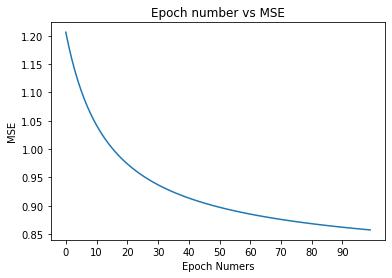

In [16]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(epochs)],MSE_list)
v=plt.xticks(ticks=list(range(0,epochs,10)))
plt.xlabel('Epoch Numers')
plt.ylabel('MSE')
plt.title('Epoch number vs MSE')
plt.show()

### Predicting Gender of the user given User Features

In [17]:
user_info_df = pd.read_csv('../input/movie-rating-recommendation/user_info.csv')
user_info_df

,user_id,age,is_male,orig_user_id
0,0,24,1,1
1,1,53,0,2
2,2,23,1,3
3,3,24,1,4
4,4,33,0,5
...,...,...,...,...
938,938,26,0,939
939,939,32,1,940
940,940,20,1,941
941,941,48,0,942


### Distribution of User Age


Text(0.5, 1.0, 'Distribution of Age across All users')

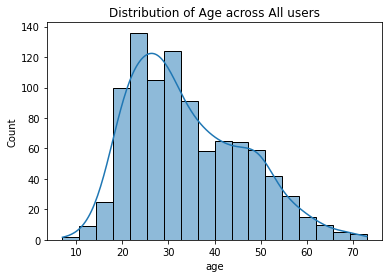

In [18]:
ax = sns.histplot(user_info_df['age'],kde=True)
ax.set_title("Distribution of Age across All users")

### Distribution of Age for Male and Female

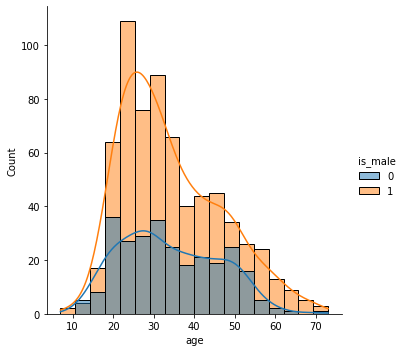

In [19]:
sns.displot(user_info_df, x="age", hue="is_male", kde=True)

## Logistic Regression Gender prediction

In [20]:
X_train = U
y_train = user_info_df['is_male']

In [21]:
clf = LogisticRegression(random_state=0, penalty='l2',solver='sag').fit(X_train, y_train)

In [22]:
accuracy = clf.score(X_train,y_train)
print("Logistic Regression Accuracy ",accuracy)


Logistic Regression Accuracy  0.7104984093319194


In [23]:
logistic_f1 = f1_score(y_train,clf.predict(X_train))
print("Logistic Regression F1 score ",logistic_f1)

Logistic Regression F1 score  0.8307501549907006


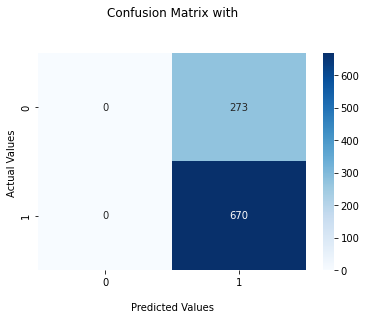

In [24]:
y_train_pred = clf.predict(X_train)
cm= confusion_matrix(  y_train,y_train_pred) 
ax = sns.heatmap(cm, annot=True, cmap='Blues',fmt="d")
ax.set_title('Confusion Matrix with\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])
## Display the visualization of the Confusion Matrix.
plt.show()

## Decision Tree Classfier Gender prediction

In [25]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [26]:
accuracy = rf.score(X_train,y_train)
print("Accuracy for Random Forest classfier ", accuracy)

Accuracy for Random Forest classfier  1.0


[[273   0]
 [  0 670]]


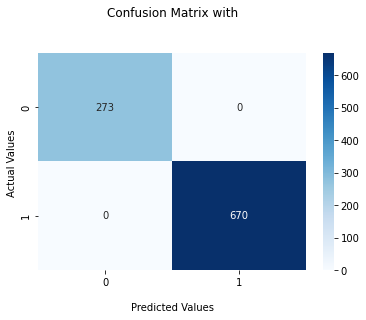

In [27]:
y_train_pred = rf.predict(X_train)
cm= confusion_matrix(  y_train,y_train_pred) 
print(cm)
ax = sns.heatmap(cm, annot=True, cmap='Blues',fmt="d")
ax.set_title('Confusion Matrix with\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])
## Display the visualization of the Confusion Matrix.
plt.show()

### Observation
* Logistic Regression Accuracy 0.71 and F1 score 0.83
* For Logistic Regression There are **Zero True Negative (TN)** and **Zero False Negative (FN)** 
* Random Forest classfier gives 100 percent accuracy
* There are **Zero False Negative (FN)** and **Zero False Positive(FP)**.


